In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

In [2]:
train_files = sorted(glob('/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/*'))
test_files = sorted(glob('/home/temp_1/kangsanha/Competition/DACON/Lesion/data/test/*'))

In [3]:
train_files

['/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100000.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100001.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100002.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100003.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100004.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100005.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100006.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100007.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100008.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100009.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100010.json',
 '/home/temp_1/kangsanha/Competition/DACON/Lesion/data/train/train_100011.json',
 '/home/temp_1/kangsanha/Com

In [4]:
train_json_list = []
for file in tqdm(train_files):
    with open(file,"r") as json_file:
        train_json_list.append(json.load(json_file))

test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))

100%|███████████████████████████████████| 20874/20874 [00:06<00:00, 3228.72it/s]


In [5]:
label_count = {}
for data in train_json_list:
    for shape in data['shapes']:
        try:
            label_count[shape['label']]+=1
        except:
            label_count[shape['label']]=1

In [6]:
label_count

{'04_lymph': 12002, '01_ulcer': 38958, '02_mass': 9760, '05_bleeding': 19498}

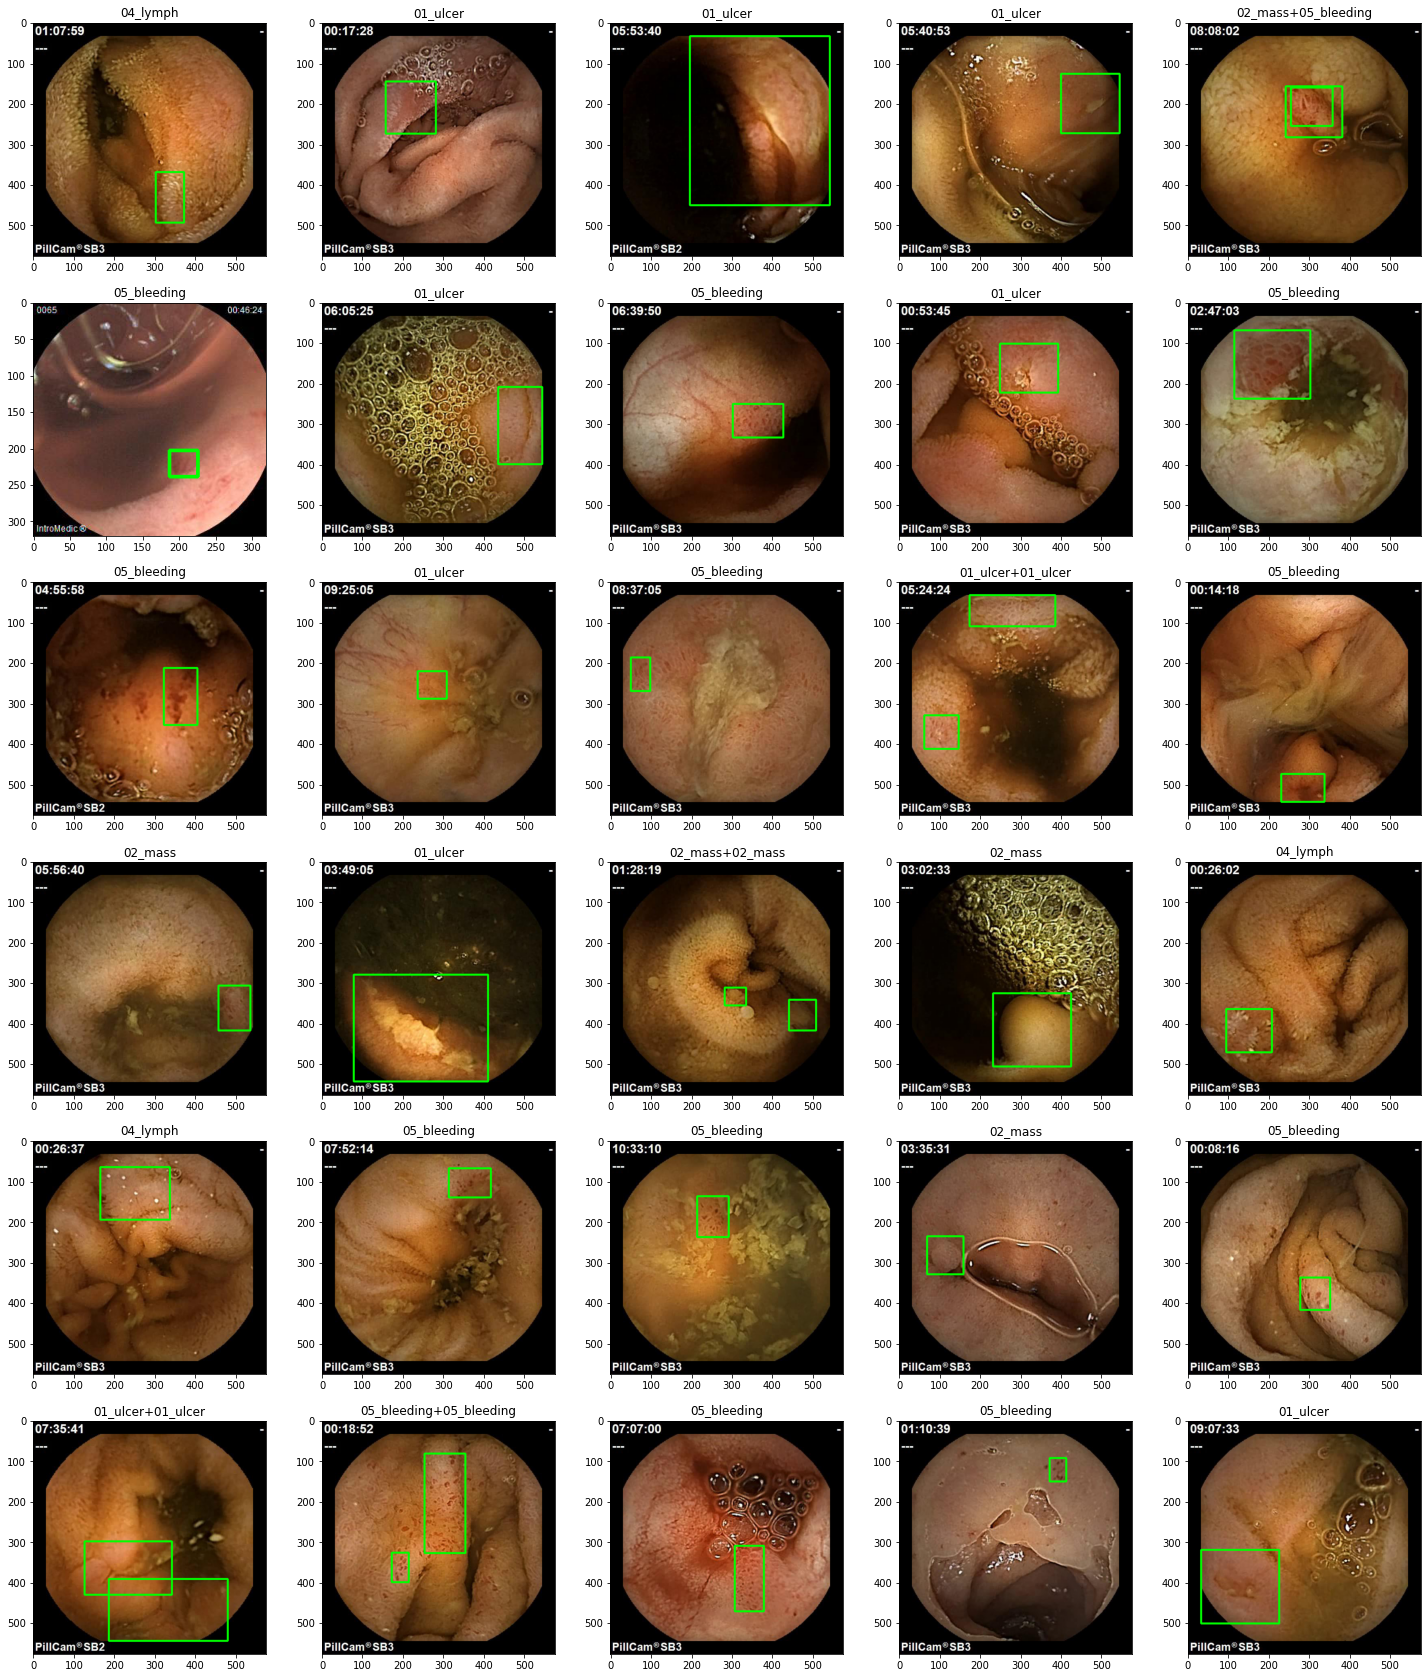

In [7]:
plt.figure(figsize=(25,30))
for i in range(30):
    plt.subplot(6,5,i+1)
    # base64 형식을 array로 변환
    img = Image.open(BytesIO(base64.b64decode(train_json_list[i]['imageData'])))
    img = np.array(img, np.uint8)
    title = []
    for shape in train_json_list[i]['shapes']:
        points = np.array(shape['points'], np.int32)
        cv2.polylines(img, [points], True, (0,255,0), 3)
        title.append(shape['label'])
    title = '+'.join(title)
    plt.imshow(img)
    plt.subplot(6,5,i+1).set_title(title)
plt.show()

In [8]:
class LesionDataset(Dataset):
    def __init__(self, json_list, mode='train'):
        self.mode = mode
        self.file_name = [json_file['file_name'] for json_file in json_list]
        if mode == 'train':
            self.labels = []
            for data in json_list:
                label = []
                for shapes in data['shapes']:
                    label.append(shapes['label'])
                self.labels.append(label)
            self.points = []
            for data in json_list:
                point = []
                for shapes in data['shapes']:
                    point.append(shapes['points'])
                self.points.append(point)
        self.imgs = [data['imageData'] for data in json_list]
        
        self.widths = [data['imageWidth'] for data in json_list]
        self.heights = [data['imageHeight'] for data in json_list]
        
        self.label_map ={
            '01_ulcer':1, '02_mass':2, '04_lymph':3, '05_bleeding':4
        }
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        file_name = self.file_name[i]
        img = Image.open(BytesIO(base64.b64decode(self.imgs[i])))
        img = self.transforms(img)
        
        target = {}
        if self.mode == 'train':
            boxes = []
            for point in self.points[i]:
                x_min = int(np.min(np.array(point)[:,0]))
                x_max = int(np.max(np.array(point)[:,0]))
                y_min = int(np.min(np.array(point)[:,1]))
                y_max = int(np.max(np.array(point)[:,1]))
                boxes.append([x_min, y_min, x_max, y_max])
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            label = [self.label_map[label] for label in self.labels[i]]

            masks = []
            for box in boxes:
                mask = np.zeros([int(self.heights[i]), int(self.widths[i])], np.uint8)
                masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

            masks = torch.tensor(masks, dtype=torch.uint8)

            target["boxes"] = boxes
            target["labels"] = torch.tensor(label, dtype=torch.int64)
            target["masks"] = masks
            target["area"] = area
            target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([i], dtype=torch.int64)
        if self.mode == 'test':
            target["file_name"] = file_name
        return img, target

In [10]:
train_dataset = LesionDataset(train_json_list, mode='train')
test_dataset = LesionDataset(test_json_list, mode='test')

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_dataset = LesionDataset(train_json_list, mode='train')

torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=16,
    collate_fn=collate_fn)

In [13]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# class 4 + background 1 = 5
num_classes = 5

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [16]:
class SmoothedValue(object):
    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)
    
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))
        
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def reduce_dict(input_dict, average=True):
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
     
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [17]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [19]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

Epoch: [0]  [   0/7828]  eta: 7:04:25  lr: 0.000002  loss: 1.7759 (1.7759)  loss_classifier: 0.4004 (0.4004)  loss_box_reg: 0.1067 (0.1067)  loss_mask: 1.1808 (1.1808)  loss_objectness: 0.0798 (0.0798)  loss_rpn_box_reg: 0.0081 (0.0081)  time: 3.2531  data: 2.4020  max mem: 10580
Epoch: [0]  [ 100/7828]  eta: 1:52:17  lr: 0.000102  loss: 0.8883 (1.1443)  loss_classifier: 0.1525 (0.2176)  loss_box_reg: 0.1039 (0.0991)  loss_mask: 0.5644 (0.7533)  loss_objectness: 0.0445 (0.0668)  loss_rpn_box_reg: 0.0063 (0.0075)  time: 0.8552  data: 0.0231  max mem: 10581
Epoch: [0]  [ 200/7828]  eta: 1:50:01  lr: 0.000202  loss: 0.7574 (0.9755)  loss_classifier: 0.1627 (0.1907)  loss_box_reg: 0.1141 (0.1069)  loss_mask: 0.4425 (0.6165)  loss_objectness: 0.0390 (0.0544)  loss_rpn_box_reg: 0.0062 (0.0070)  time: 0.8609  data: 0.0219  max mem: 10582
Epoch: [0]  [ 300/7828]  eta: 1:48:38  lr: 0.000302  loss: 0.7634 (0.9027)  loss_classifier: 0.1669 (0.1845)  loss_box_reg: 0.1360 (0.1143)  loss_mask: 0.407

Epoch: [0]  [3000/7828]  eta: 1:10:43  lr: 0.001000  loss: 0.5295 (0.6144)  loss_classifier: 0.1021 (0.1313)  loss_box_reg: 0.1152 (0.1243)  loss_mask: 0.2839 (0.3367)  loss_objectness: 0.0095 (0.0175)  loss_rpn_box_reg: 0.0040 (0.0046)  time: 0.8827  data: 0.0237  max mem: 10582
Epoch: [0]  [3100/7828]  eta: 1:09:15  lr: 0.001000  loss: 0.5172 (0.6118)  loss_classifier: 0.1035 (0.1306)  loss_box_reg: 0.1126 (0.1242)  loss_mask: 0.2802 (0.3351)  loss_objectness: 0.0095 (0.0173)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.8783  data: 0.0209  max mem: 10582
Epoch: [0]  [3200/7828]  eta: 1:07:48  lr: 0.001000  loss: 0.5297 (0.6088)  loss_classifier: 0.1024 (0.1298)  loss_box_reg: 0.1112 (0.1240)  loss_mask: 0.2741 (0.3334)  loss_objectness: 0.0078 (0.0171)  loss_rpn_box_reg: 0.0036 (0.0045)  time: 0.8798  data: 0.0226  max mem: 10582
Epoch: [0]  [3300/7828]  eta: 1:06:20  lr: 0.001000  loss: 0.4954 (0.6059)  loss_classifier: 0.1026 (0.1290)  loss_box_reg: 0.1053 (0.1237)  loss_mask: 0.270

Epoch: [0]  [6000/7828]  eta: 0:26:50  lr: 0.001000  loss: 0.5019 (0.5609)  loss_classifier: 0.1042 (0.1169)  loss_box_reg: 0.1154 (0.1198)  loss_mask: 0.2656 (0.3064)  loss_objectness: 0.0086 (0.0137)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 0.8854  data: 0.0239  max mem: 10582
Epoch: [0]  [6100/7828]  eta: 0:25:22  lr: 0.001000  loss: 0.4899 (0.5597)  loss_classifier: 0.0916 (0.1165)  loss_box_reg: 0.1133 (0.1197)  loss_mask: 0.2590 (0.3058)  loss_objectness: 0.0073 (0.0136)  loss_rpn_box_reg: 0.0034 (0.0041)  time: 0.8814  data: 0.0219  max mem: 10582
Epoch: [0]  [6200/7828]  eta: 0:23:54  lr: 0.001000  loss: 0.4893 (0.5586)  loss_classifier: 0.0864 (0.1162)  loss_box_reg: 0.1125 (0.1196)  loss_mask: 0.2675 (0.3052)  loss_objectness: 0.0074 (0.0135)  loss_rpn_box_reg: 0.0033 (0.0041)  time: 0.8760  data: 0.0208  max mem: 10582
Epoch: [0]  [6300/7828]  eta: 0:22:26  lr: 0.001000  loss: 0.5114 (0.5576)  loss_classifier: 0.0989 (0.1159)  loss_box_reg: 0.1185 (0.1195)  loss_mask: 0.271

Epoch: [1]  [ 900/7828]  eta: 1:42:06  lr: 0.001000  loss: 0.4586 (0.4759)  loss_classifier: 0.0881 (0.0934)  loss_box_reg: 0.1036 (0.1114)  loss_mask: 0.2562 (0.2596)  loss_objectness: 0.0070 (0.0082)  loss_rpn_box_reg: 0.0032 (0.0034)  time: 0.8794  data: 0.0230  max mem: 10582
Epoch: [1]  [1000/7828]  eta: 1:40:35  lr: 0.001000  loss: 0.4493 (0.4748)  loss_classifier: 0.0893 (0.0931)  loss_box_reg: 0.1053 (0.1111)  loss_mask: 0.2485 (0.2591)  loss_objectness: 0.0052 (0.0081)  loss_rpn_box_reg: 0.0028 (0.0034)  time: 0.8820  data: 0.0230  max mem: 10582
Epoch: [1]  [1100/7828]  eta: 1:39:04  lr: 0.001000  loss: 0.4456 (0.4743)  loss_classifier: 0.0868 (0.0930)  loss_box_reg: 0.1049 (0.1109)  loss_mask: 0.2383 (0.2590)  loss_objectness: 0.0047 (0.0080)  loss_rpn_box_reg: 0.0028 (0.0034)  time: 0.8850  data: 0.0229  max mem: 10582
Epoch: [1]  [1200/7828]  eta: 1:37:33  lr: 0.001000  loss: 0.4914 (0.4749)  loss_classifier: 0.0965 (0.0931)  loss_box_reg: 0.1200 (0.1111)  loss_mask: 0.266

KeyboardInterrupt: 

In [20]:
threshold = 0.8
results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}
model.eval()
for img, target in tqdm(test_dataset):
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    idx = np.where(prediction['scores'].cpu().numpy() > threshold)[0]
    for i in idx:
        x_min, y_min, x_max, y_max = prediction['boxes'].cpu().numpy()[i]
        class_id = prediction['labels'].cpu().numpy()[i]
        confidence = prediction['scores'].cpu().numpy()[i]
        
        results['file_name'].append(target['file_name'])
        results['class_id'].append(class_id)
        results['confidence'].append(confidence)
        results['point1_x'].append(x_min)
        results['point1_y'].append(y_min)
        results['point2_x'].append(x_max)
        results['point2_y'].append(y_min)
        results['point3_x'].append(x_max)
        results['point3_y'].append(y_max)
        results['point4_x'].append(x_min)
        results['point4_y'].append(y_max)

100%|█████████████████████████████████████| 20874/20874 [20:49<00:00, 16.70it/s]


In [21]:
submission = pd.DataFrame(results)
submission.shape

(20311, 11)

In [22]:
submission.head()

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200001.json,1,0.968097,407.270752,187.552322,519.812073,187.552322,519.812073,311.418518,407.270752,311.418518
1,test_200001.json,1,0.965011,112.632454,330.695343,266.164154,330.695343,266.164154,485.119720,112.632454,485.119720
2,test_200002.json,2,0.877328,220.961945,347.447418,311.918030,347.447418,311.918030,459.650543,220.961945,459.650543
3,test_200003.json,2,0.963045,224.117477,133.571884,315.627899,133.571884,315.627899,261.861542,224.117477,261.861542
4,test_200003.json,2,0.951249,137.378143,3.079230,292.372223,3.079230,292.372223,193.956497,137.378143,193.956497


In [23]:
submission.to_csv('result.csv', index=False)